# Azure Anomaly Detector Tests

We test out Azure's anomaly detector using the free bucks on a personal account.


## Authenticating the Client

Before using the container we pass the api key and endpoint location as environment variables.


In [18]:
from azure.cognitiveservices.anomalydetector import AnomalyDetectorClient
from msrest.authentication import CognitiveServicesCredentials
import os


# variables that come from the microsoft page
# this sample assumes you have created an environment variable for your key and endpoint
# heck the Anomaly detector tutorial on how to create them
SUBSCRIPTION_KEY = os.environ["ANOMALY_DETECTOR_KEY"]
ANOMALY_DETECTOR_ENDPOINT = os.environ["ANOMALY_DETECTOR_ENDPOINT"]

client = AnomalyDetectorClient(ANOMALY_DETECTOR_ENDPOINT, 
                               CognitiveServicesCredentials(SUBSCRIPTION_KEY))

## Loading the time series and Request

Having client ready let's import data examples. Then, create a request object and set the granularity 
(or periodicity, i.e.: Granularity.daily) of data points.

In [19]:
import pandas as pd
from azure.cognitiveservices.anomalydetector.models import Point, Request, Granularity


TIME_SERIES_DATA_PATH = "./example-data/request-data.csv"
series = []
data = pd.read_csv(TIME_SERIES_DATA_PATH, header=None, encoding='utf-8', parse_dates=[0])
for index, row in data.iterrows():
    series.append(Point(timestamp=row[0], value=row[1]))

request = Request(series=series, granularity=Granularity.daily)

## Using the anomaly detector in an entire data point

We have two modes of using the anomaly detector: by processing the entire time series or 
going live with the single data point processing, we start with the entire processing.

In [20]:
from azure.cognitiveservices.anomalydetector.models import APIErrorException


print('Detecting anomalies in the entire time series.')
response = None
try:
    response = client.entire_detect(request)
except Exception as e:
    if isinstance(e, APIErrorException):
        print('Error code: {}'.format(e.error.code), 'Error message: {}'.format(e.error.message))
    else:
        print(e)

freaks = [index for index, value in enumerate(response.is_anomaly) if value]
print('{} anomalies in the Series'.format(len(freaks)))

# print the time-series with highlight in anomalies
# it seems easier to plot from the DataFrame than the Point series
data.head()


Detecting anomalies in the entire time series.
14 anomalies in the Series


,0,1
0,2018-03-01 00:00:00+00:00,32858923
1,2018-03-02 00:00:00+00:00,29615278
2,2018-03-03 00:00:00+00:00,22839355
3,2018-03-04 00:00:00+00:00,25948736
4,2018-03-05 00:00:00+00:00,34139159


## Visualizing the Anomalies

Nice it works really bad, even though it's their example data which is stationary (can be used
on non stationary but with a flat trend). Let's make a cute graph to show the anomalies it reports.

d:\projects\azure-containers\venv\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


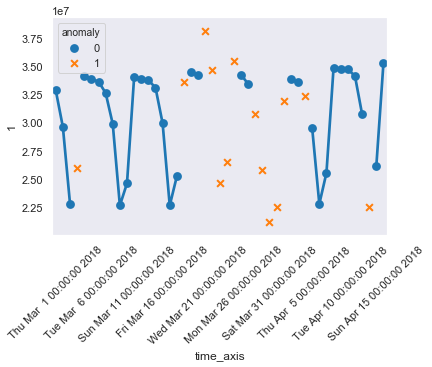

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# first we have to convert timestamp to time format else we can't plot
timestamps = data[data.columns[0]].tolist()
data['time_axis'] = [a_stamp.ctime() for a_stamp in data[data.columns[0]]]

# now we save freak indexes as a mask
data['anomaly'] = np.zeros(len(data['time_axis']), dtype=int)
data['anomaly'][freaks] = 1

# make the seaborn plot
fig, ax = plt.subplots()
# set the style 
sns.set_context('notebook')
sns.set_style('dark')
# set the series
point_plt = sns.pointplot(x='time_axis', y=data.columns[1], data=data, hue='anomaly', ax=ax, 
                          markers=["o", "x"], linestyles=["-", ""])
# set tick frequency and orientation
point_plt.set_xticklabels(point_plt.get_xticklabels(), rotation=45)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 5 == 0:  # every nth label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.show()

## Using a custom Dataset: MSFT NASDAQ

To check out if we learned something, we exported the NASDAQ price of Microsoft from somewhere, 
let's check for anomalies on it's trade value! Note that we don't import shit because we 
already did on blocks above.


Detecting anomalies in the entire time series.
259 anomalies in the Series


d:\projects\azure-containers\venv\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


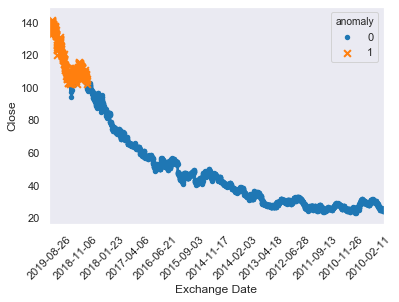

In [37]:
import time


# format is to append data as a Point series
data_path = './example-data/MSFT.O DAILY LONG.csv'
data = pd.read_csv(data_path)

# transform my time to iso 8601 format (how stupid is this?)
iso_dates = [time.strftime('%Y-%m-%dT%H:%M:%SZ', time.strptime(a_date, "%Y-%m-%d")) 
             for a_date in data['Exchange Date']]

# we start appending at the beginning because series is inverted (fucking thompson)
series = []
for a_date, a_change in zip(iso_dates, data['Close']):
    series.insert(0, Point(timestamp=a_date, value=a_change))

# now we create a request
request = Request(series=series, granularity=Granularity.daily)

# now request the results
print('Detecting anomalies in the entire time series.')
response = None
try:
    response = client.entire_detect(request)
except Exception as e:
    if isinstance(e, APIErrorException):
        print('Error code: {}'.format(e.error.code), 'Error message: {}'.format(e.error.message))
    else:
        print(e)

freaks = [index for index, value in enumerate(response.is_anomaly) if value]
print('{} anomalies in the Series'.format(len(freaks)))

# now we plot the results
# first, let's remember we have the series inverted, therefore
length = len(series)
freaks = [length - a_freak for a_freak in reversed(freaks)]
# we add the freaks mask to the data
data['anomaly'] = np.zeros(len(series), dtype=int)
data['anomaly'][freaks] = 1
# make the seaborn plot
fig, ax = plt.subplots()
# set the style 
sns.set_context('notebook')
sns.set_style('dark')
# set the series
point_plt = sns.pointplot(x='Exchange Date', y='Close', data=data, hue='anomaly', ax=ax, 
                          markers=[".", "x"], linestyles=["-", ""])
# set tick frequency and orientation
point_plt.set_xticklabels(point_plt.get_xticklabels(), rotation=45)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 200 == 0:  # every nth label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.show()